# 1) Imports

#### PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR

In [2]:
print('PyTorch version', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

PyTorch version 2.9.1+cu128
Device: cuda


#### General

In [3]:
import os
import json
import math
import time
import random
from pathlib import Path
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

#### Monai

In [4]:
import monai
print("MONAI version:", monai.__version__)

/home/usrs/hnoel/miniconda3/envs/monai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.5.1


In [5]:
from monai.networks.nets import SegResNet
from monai.losses import DiceCELoss
from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    ScaleIntensityd,
    RandFlipd,
    RandRotated,
    RandAffined,
    Resized,
    EnsureTyped,
)

# 2) Parameters

#### 2.1) Directories

In [6]:
drive_root = Path("/home/usrs/hnoel/STARE_704")

# TRAIN
train_images_dir = drive_root / "training" / "images"
train_manual_dir = drive_root / "training" / "masks"         

# TEST 
test_images_dir  = drive_root / "test" / "images"
test_manual_dir  = drive_root / "test" / "masks"       

#### 2.2) Hyperparameters

In [7]:
# Image sizes
IMG_HEIGHT = 704
IMG_WIDTH  = 704

# Batch size
BATCH_SIZE = 6

# Number of epochs
EPOCHS = 300

# Learning rate
LR = 1e-3

# Classes
NUM_CLASSES = 2
BACKGROUND_IDX = 0
VESSEL_CLASS = 1

#### 2.3) Seed

In [8]:
SEED = 42

# Python
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Monai
set_determinism(seed=SEED)

print(f"Seed fixed to {SEED}")

Seed fixed to 42


#### 2.4) Save directories

In [11]:
model_name = "SegResNet_STARE_v1"

# Courbes, JSON, figures, etc.
data_dir = Path("/home/usrs/hnoel/Tohoku/Monai/SegResNet") / model_name
data_dir.mkdir(parents=True, exist_ok=True)

# Poids de modèles
models_dir = Path("/home/usrs/hnoel/MODELS/SegResNet") / model_name
models_dir.mkdir(parents=True, exist_ok=True)

# 3) DataLoaders

#### 3.1) Data augmentation

In [12]:
final_size = (IMG_HEIGHT, IMG_WIDTH)   # (704, 704) maintenant

train_transforms = Compose([
    ScaleIntensityd(keys=["image"]),

    # ---- AUGMENTATIONS ----
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.6),
    RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.6),

    RandRotated(
        keys=["image", "label"],
        range_x=np.pi/8,        # ±22.5°
        prob=0.3,
        mode=("bilinear", "nearest"),
    ),

    RandAffined(
        keys=["image", "label"],
        prob=0.3,
        rotate_range=(-np.pi/12, np.pi/12),
        translate_range=(20, 20),
        scale_range=(0.05, 0.05),
        mode=("bilinear", "nearest"),
    ),

    Resized(
        keys=["image", "label"],
        spatial_size=final_size,
        mode=("bilinear", "nearest"),
    ),

    EnsureTyped(keys=["image", "label"]),
])

val_transforms = Compose([
    ScaleIntensityd(keys=["image"]),
    Resized(
        keys=["image", "label"],
        spatial_size=final_size,
        mode=("bilinear", "nearest"),
    ),
    EnsureTyped(keys=["image", "label"]),
])


#### 3.2) Create the class fot the DRIVE datset images

In [13]:
class StareDataset(Dataset):
    def __init__(self, img_dir, manual_dir,
                 img_size=(IMG_HEIGHT, IMG_WIDTH),
                 transforms=None,
                 indices=None):

        self.img_paths = sorted(list(Path(img_dir).glob("*.png")))
        self.manual_dir = Path(manual_dir)
        self.H, self.W = img_size
        self.transforms = transforms
        self.indices = indices

    def __len__(self):
        if self.indices is None:
            return len(self.img_paths)
        return len(self.indices)

    def _get_paths(self, idx):
        if self.indices is not None:
            idx = self.indices[idx]

        img_path = self.img_paths[idx]

        # base = "im0082"
        base = img_path.stem

        # mask = "im0082_masks.png"
        manual_path = self.manual_dir / f"{base}_mask.png"

        if not manual_path.exists():
            raise FileNotFoundError(f"Mask not found: {manual_path}")

        return img_path, manual_path

    def __getitem__(self, idx):
        img_path, manual_path = self._get_paths(idx)

        H, W = self.H, self.W

        # === Image RGB ===
        img = Image.open(img_path).convert("RGB")
        img = img.resize((W, H), Image.BILINEAR)
        img_np = np.array(img).astype(np.float32) / 255.0
        img_t = torch.from_numpy(img_np).permute(2, 0, 1)

        # === Ground truth (binary) ===
        gt = Image.open(manual_path).convert("L")
        gt = gt.resize((W, H), Image.NEAREST)
        gt_np = np.array(gt)

        label_np = np.zeros_like(gt_np, dtype=np.int64)
        label_np[gt_np > 0] = VESSEL_CLASS
        label_t = torch.from_numpy(label_np).long().unsqueeze(0)

        sample = {"image": img_t, "label": label_t}

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample


In [14]:
# ========= Préparation des indices train / val pour STARE (10 images) =========
train_img_paths_all = sorted(list(Path(train_images_dir).glob("*.png")))
n_total = len(train_img_paths_all)      # normalement 10

indices_all = list(range(n_total))
train_indices = indices_all[:8]
val_indices   = indices_all[8:]         # 2 dernières

print("Train indices:", train_indices)
print("Val indices:  ", val_indices)


Train indices: [0, 1, 2, 3, 4, 5, 6, 7]
Val indices:   [8, 9]


In [15]:
train_ds = StareDataset(
    train_images_dir,
    train_manual_dir,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    transforms=train_transforms,
    indices=train_indices,
)

val_ds = StareDataset(
    train_images_dir,
    train_manual_dir,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    transforms=val_transforms,
    indices=val_indices,
)

test_ds = StareDataset(
    test_images_dir,
    test_manual_dir,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    transforms=val_transforms,
    indices=None,
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Train / Val / Test sizes:", len(train_ds), len(val_ds), len(test_ds))


Train / Val / Test sizes: 8 2 10


# 4) UNet Model

In [16]:
model = SegResNet(
    spatial_dims=2,          # DRIVE = 2D
    in_channels=3,           # images en 3 channels
    out_channels=2,          # background / vessel
    blocks_down=[1, 2, 2, 4],  # structure proche du papier (réduction)
    init_filters=32,         # fidèle au papier
    blocks_up=[1, 1, 1],
    norm=("GROUP", {"num_groups": 8}),          # GroupNorm comme dans papier
    dropout_prob=0.2         # recommandé (papier = dropout spatial 0.2)
).to(device)

In [17]:
print(model.__class__.__name__, "initialized on", device)

SegResNet initialized on cuda


# 5) Optimizer

In [18]:
optimizer = optim.AdamW(
    model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=1e-2
    )

# 6) Scheduler

In [19]:
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=50,   # tous les 50 epochs
    gamma=0.5       # LR = LR * 0.5
)

# 7) Loss function

In [20]:
# Pour DRIVE (binaire), on commence sans pondération explicite des classes.
# Si besoin, on pourra recalculer des poids plus tard à partir des fréquences de pixels.
weights = None

In [21]:
loss_function = DiceCELoss(
    include_background=False,   # on ne compte pas le background dans le Dice
    to_onehot_y=True,
    softmax=True,
    weight=weights,
    lambda_dice=1.0,
    lambda_ce=1.0,
)

# 8) History and metrics

In [22]:
best_val_loss = float("inf")
best_val_dice = -float("inf")

In [23]:
# ===========================================
#   DICTIONNAIRES STOCRAGE (MEAN ONLY)
# ===========================================

train_history = {
    "loss": [],
    "accuracy":   [],
    "dice":       [],
    "iou":        [],
    "precision":  [],
    "recall":     [],
    "sensitivity":[],
    "specificity":[],
    "auc":        [],
    "lr":         [],
    "alpha":      []
}

val_history = {
    "loss": [],
    "accuracy":   [],
    "dice":       [],
    "iou":        [],
    "precision":  [],
    "recall":     [],
    "sensitivity":[],
    "specificity":[],
    "auc":        []
}

In [24]:
def init_confmat_sums(num_classes=NUM_CLASSES):
    """
    Agrégats TP/FP/FN/TN sur l'ensemble du dataset.
    N = nombre de pixels pris en compte (dans le FOV).
    """
    sums = {
        "TP": np.zeros(num_classes, dtype=np.int64),
        "FP": np.zeros(num_classes, dtype=np.int64),
        "FN": np.zeros(num_classes, dtype=np.int64),
        "TN": np.zeros(num_classes, dtype=np.int64),
        "N":  0,
    }
    return sums

In [25]:
def init_auc_buffers(classes):
    """
    Buffers pour stocker y_true / y_score par classe (liste d'indices de classes).
    Exemple : classes = [VESSEL_CLASS].
    """
    buffers = {}
    for c in classes:
        buffers[c] = {"y_true": [], "y_score": []}
    return buffers

In [26]:
def update_confmat_sums(sums, preds, targets, num_classes=NUM_CLASSES, fov=None):
    """
    Mets à jour TP/FP/FN/TN en tenant compte éventuellement du FOV.
    - preds   : (B,H,W)
    - targets : (B,H,W) ou (B,1,H,W)
    - fov     : (B,H,W) ou (B,1,H,W), bool ou {0,1}; si None => tout le carré
    """
    with torch.no_grad():
        # Harmonisation des shapes
        if targets.dim() == 4:
            targets = targets.squeeze(1)          # (B,H,W)
        if fov is not None and fov.dim() == 4:
            fov = fov.squeeze(1)                  # (B,H,W)

        # Masque FOV binaire, si fourni
        if fov is not None:
            f = fov.bool()
        else:
            f = None

        for c in range(num_classes):
            p = (preds == c)
            t = (targets == c)

            if f is not None:
                p = p & f
                t = t & f

            tp = (p & t).sum().item()
            fp = (p & ~t).sum().item()
            fn = (~p & t).sum().item()
            tn = (~p & ~t).sum().item()

            sums["TP"][c] += tp
            sums["FP"][c] += fp
            sums["FN"][c] += fn
            sums["TN"][c] += tn

        if f is not None:
            sums["N"] += f.sum().item()
        else:
            sums["N"] += targets.numel()

In [27]:
def update_auc_buffers(buffers, logits, targets, fov=None):
    """
    Mets à jour les buffers pour AUC.
    - logits : (B,C,H,W)
    - targets: (B,H,W) ou (B,1,H,W)
    - fov    : (B,H,W) ou (B,1,H,W), bool ou {0,1}; si None => tout le carré
    """
    with torch.no_grad():
        if targets.dim() == 4:
            targets = targets.squeeze(1)          # (B,H,W)
        if fov is not None and fov.dim() == 4:
            fov = fov.squeeze(1)                  # (B,H,W)

        probs = F.softmax(logits, dim=1)          # (B,C,H,W)
        B, C, H, W = probs.shape

        # aplatir
        flat_probs = probs.permute(0, 2, 3, 1).reshape(-1, C)  # (B*H*W, C)
        flat_t     = targets.reshape(-1)                       # (B*H*W,)

        if fov is not None:
            flat_f = fov.reshape(-1).bool()
            flat_probs = flat_probs[flat_f]
            flat_t     = flat_t[flat_f]

        for c, pack in buffers.items():
            y_true  = (flat_t == c).cpu().numpy().astype(np.uint8)
            y_score = flat_probs[:, c].cpu().numpy()

            # cas dégénérés : pas de pos ou pas de neg => AUC non définie
            pos = (y_true == 1).sum()
            neg = (y_true == 0).sum()
            if pos == 0 or neg == 0:
                continue

            pack["y_true"].append(y_true)
            pack["y_score"].append(y_score)

In [28]:
def compute_scalar_metrics_from_confmat(sums, include_classes):
    """
    Calcule accuracy / precision / recall / specificity / dice / IoU
    en moyenne sur les classes listées (ex: [VESSEL_CLASS]).
    """
    TP, FP, FN, TN = sums["TP"], sums["FP"], sums["FN"], sums["TN"]
    eps = 1e-7

    acc_c  = (TP + TN) / np.maximum(TP + TN + FP + FN, eps)
    prec_c = TP / np.maximum(TP + FP, eps)
    rec_c  = TP / np.maximum(TP + FN, eps)
    spec_c = TN / np.maximum(TN + FP, eps)
    dice_c = (2 * TP) / np.maximum(2 * TP + FP + FN, eps)
    iou_c  = TP / np.maximum(TP + FP + FN, eps)

    idx = np.array(include_classes, dtype=int)
    return {
        "accuracy":    float(np.mean(acc_c[idx])),
        "precision":   float(np.mean(prec_c[idx])),
        "recall":      float(np.mean(rec_c[idx])),
        "specificity": float(np.mean(spec_c[idx])),
        "dice":        float(np.mean(dice_c[idx])),
        "iou":         float(np.mean(iou_c[idx])),
    }

In [29]:
def compute_mean_auc(buffers):
    """
    Calcule l'AUC moyen en moyennant sur les classes présentes dans `buffers`.
    """
    aucs = []
    for c, pack in buffers.items():
        if len(pack["y_true"]) == 0:
            continue
        y_true  = np.concatenate(pack["y_true"])
        y_score = np.concatenate(pack["y_score"])

        pos = (y_true == 1).sum()
        neg = (y_true == 0).sum()
        if pos == 0 or neg == 0:
            continue

        try:
            aucs.append(roc_auc_score(y_true, y_score))
        except Exception:
            pass

    if len(aucs) == 0:
        return float("nan")
    return float(np.mean(aucs))

# 9) Training

In [30]:
for epoch in range(EPOCHS):

    # =========================
    #        TRAIN
    # =========================
    model.train()

    running_loss = 0.0
    conf_sums = init_confmat_sums()
    auc_buf   = init_auc_buffers([VESSEL_CLASS])

    for batch in train_loader:

        imgs   = batch["image"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)  # (B,1,H,W)

        optimizer.zero_grad()

        outputs = model(imgs)         # (B,C,H,W)
        loss    = loss_function(outputs, labels)  # loss attend (B,1,H,W)

        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size

        # ---- MÉTRIQUES DANS LE FOV UNIQUEMENT ----
        preds   = outputs.argmax(dim=1)          # (B,H,W)
        targets = labels.squeeze(1)              # (B,H,W)

        update_confmat_sums(conf_sums, preds, targets, NUM_CLASSES)
        update_auc_buffers(auc_buf, outputs, targets)

    train_loss   = running_loss / len(train_ds)
    train_metrics = compute_scalar_metrics_from_confmat(conf_sums, [VESSEL_CLASS])
    train_auc     = compute_mean_auc(auc_buf)

    current_lr = optimizer.param_groups[0]["lr"]

    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_metrics["accuracy"])
    train_history["dice"].append(train_metrics["dice"])
    train_history["iou"].append(train_metrics["iou"])
    train_history["precision"].append(train_metrics["precision"])
    train_history["recall"].append(train_metrics["recall"])
    train_history["specificity"].append(train_metrics["specificity"])
    train_history["auc"].append(train_auc)
    train_history["lr"].append(current_lr)

    # =========================
    #       VALIDATION
    # =========================
    model.eval()

    val_running_loss = 0.0
    conf_sums_val = init_confmat_sums()
    auc_buf_val   = init_auc_buffers(classes=[VESSEL_CLASS])

    with torch.no_grad():
        for batch in val_loader:

            imgs   = batch["image"].to(device, non_blocking=True)
            labels = batch["label"].to(device, non_blocking=True)

            outputs = model(imgs)
            loss    = loss_function(outputs, labels)

            batch_size = imgs.size(0)
            val_running_loss += loss.item() * batch_size

            preds   = outputs.argmax(dim=1)
            targets = labels.squeeze(1)

            update_confmat_sums(conf_sums_val, preds, targets, NUM_CLASSES)
            update_auc_buffers(auc_buf_val, outputs, targets)

    val_loss    = val_running_loss / len(val_ds)
    val_metrics = compute_scalar_metrics_from_confmat(conf_sums_val, [VESSEL_CLASS])
    val_auc     = compute_mean_auc(auc_buf_val)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_metrics["accuracy"])
    val_history["dice"].append(val_metrics["dice"])
    val_history["iou"].append(val_metrics["iou"])
    val_history["precision"].append(val_metrics["precision"])
    val_history["recall"].append(val_metrics["recall"])
    val_history["specificity"].append(val_metrics["specificity"])
    val_history["auc"].append(val_auc)

    # =========================
    #        LOGS
    # =========================
    print("-" * 40)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}")
    print(f"  Train Dice: {train_metrics['dice']:.4f} | Val Dice: {val_metrics['dice']:.4f}")
    print(f"  Current LR: {current_lr:.6f}")

    # =========================
    #   SAVE BEST MODELS
    # =========================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), str(models_dir / "loss_best_model_state_dict.pth"))
        torch.save(model,              str(models_dir / "loss_best_model_full.pth"))
        print("✅ New best model (loss) saved")

    if val_metrics["dice"] > best_val_dice:
        best_val_dice = val_metrics["dice"]
        torch.save(model.state_dict(), str(models_dir / "dice_best_model_state_dict.pth"))
        torch.save(model,              str(models_dir / "dice_best_model_full.pth"))
        print("✅ New best model (dice) saved")

    # =========================
    #   SCHEDULER STEP
    # =========================
    scheduler.step()

# =========================
#     SAVE LAST MODEL
# =========================
torch.save(model.state_dict(), str(models_dir / f"epoch{EPOCHS}_model_state_dict.pth"))
torch.save(model,              str(models_dir / f"epoch{EPOCHS}_model_full.pth"))
print("✅ Last model saved")


----------------------------------------
Epoch 1/300
  Train Loss: 1.3601
  Val   Loss: 1.1676
  Train Dice: 0.0953 | Val Dice: 0.0000
  Current LR: 0.001000
✅ New best model (loss) saved
✅ New best model (dice) saved
----------------------------------------
Epoch 2/300
  Train Loss: 1.2028
  Val   Loss: 1.1529
  Train Dice: 0.0000 | Val Dice: 0.0000
  Current LR: 0.001000
✅ New best model (loss) saved
----------------------------------------
Epoch 3/300
  Train Loss: 1.1723
  Val   Loss: 1.1543
  Train Dice: 0.0000 | Val Dice: 0.0000
  Current LR: 0.001000
----------------------------------------
Epoch 4/300
  Train Loss: 1.1601
  Val   Loss: 1.1978
  Train Dice: 0.0000 | Val Dice: 0.0000
  Current LR: 0.001000
----------------------------------------
Epoch 5/300
  Train Loss: 1.1650
  Val   Loss: 1.1430
  Train Dice: 0.0000 | Val Dice: 0.0000
  Current LR: 0.001000
✅ New best model (loss) saved
----------------------------------------
Epoch 6/300
  Train Loss: 1.1460
  Val   Loss: 1.

In [31]:
with open(data_dir / "UNet_train_history.json", "w") as f:
    json.dump(train_history, f, indent=4)

with open(data_dir / "UNet_val_history.json", "w") as f:
    json.dump(val_history, f, indent=4)

print("Historiques sauvegardés en JSON")

Historiques sauvegardés en JSON


# 10) Validation tests

#### 10.1) Load the model

In [32]:
model.load_state_dict(torch.load(models_dir / "dice_best_model_state_dict.pth", map_location=device, weights_only=True))
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
        (act): ReLU(inpl

#### 10.2) Images

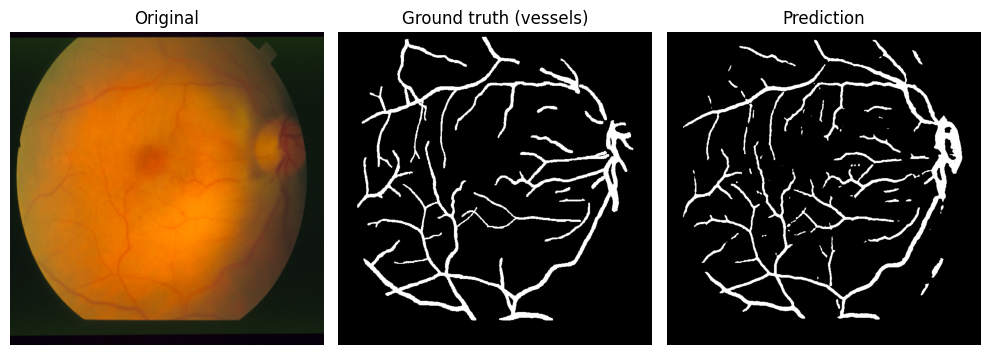

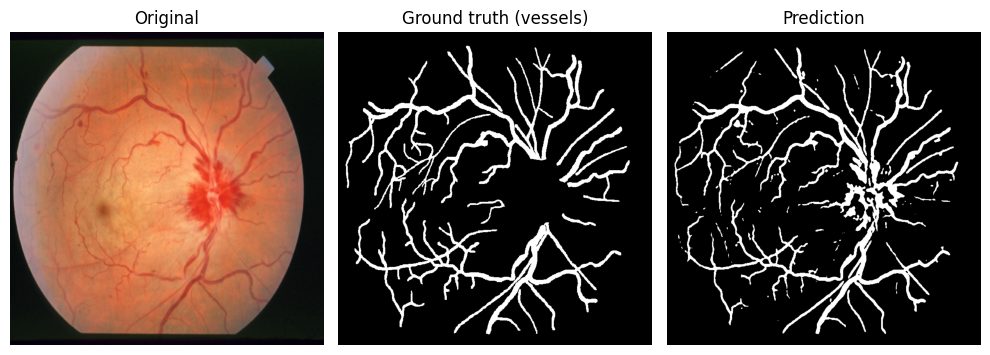

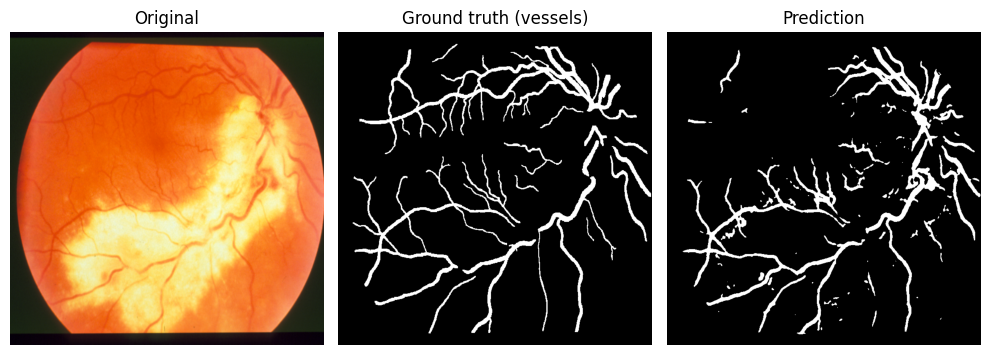

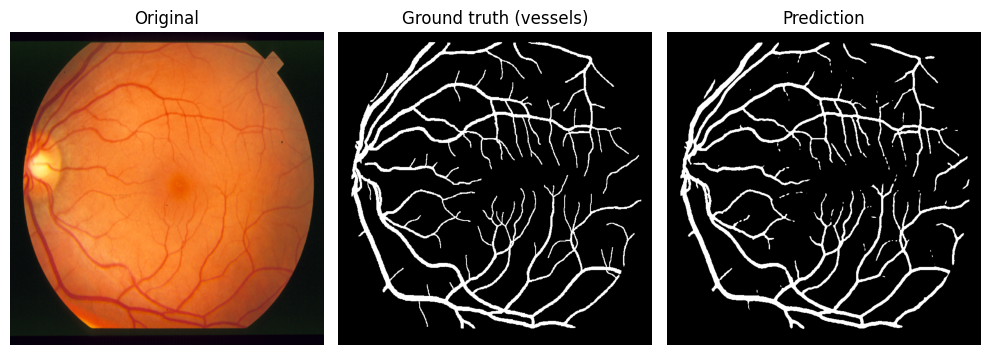

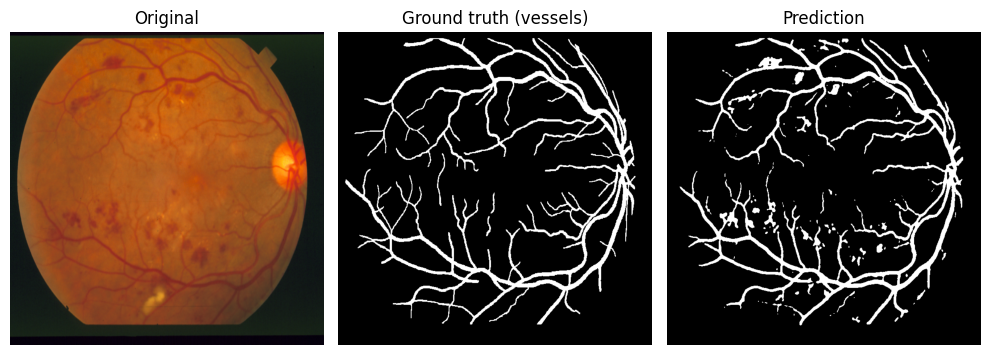

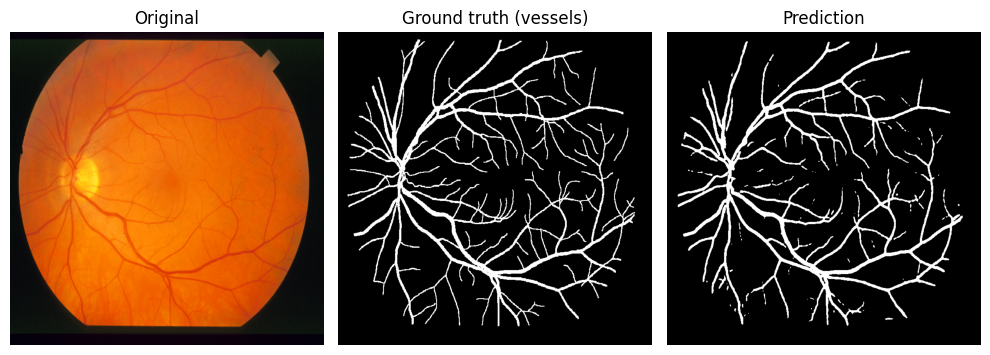

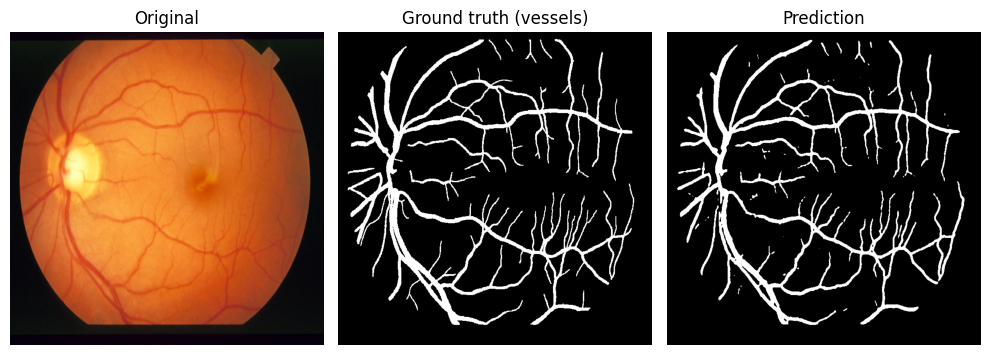

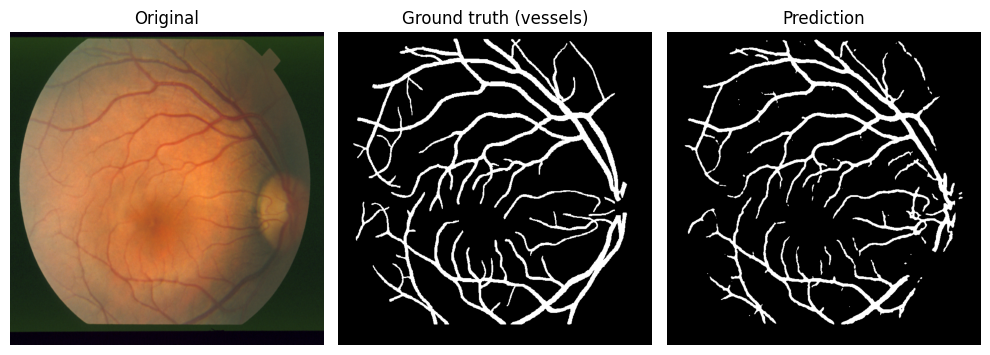

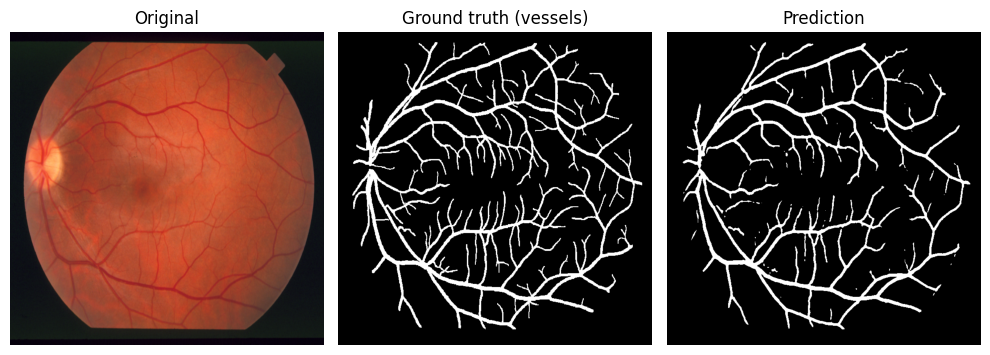

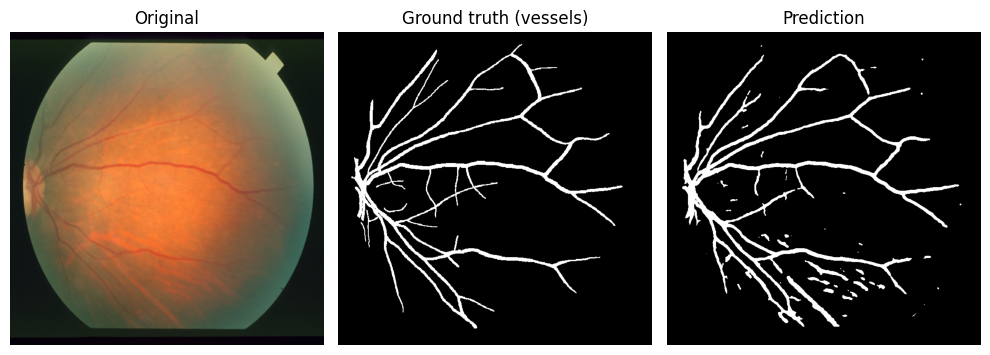

Triplets sauvegardés dans : /home/usrs/hnoel/Tohoku/Monai/SegResNet/SegResNet_STARE_v1/predictions_test_triplets


In [33]:
model.eval()

# 📁 Dossier pour sauvegarder les triplets
pred_dir = data_dir / "predictions_test_triplets"
pred_dir.mkdir(parents=True, exist_ok=True)

img_index = 0

with torch.no_grad():
    for batch in test_loader:
        imgs   = batch["image"].to(device)  # (B,3,H,W)
        labels = batch["label"].to(device)  # (B,1,H,W)

        logits = model(imgs)                # (B,2,H,W)
        preds  = logits.argmax(dim=1)       # (B,H,W)
        targets = labels.squeeze(1)         # (B,H,W)

        for i in range(imgs.size(0)):
            img_i  = imgs[i].cpu()
            gt_i   = targets[i].cpu()
            pred_i = preds[i].cpu()

            fig, ax = plt.subplots(1, 3, figsize=(10, 4))

            ax[0].imshow(img_i.permute(1, 2, 0))
            ax[0].set_title("Original")

            ax[1].imshow(gt_i, cmap="gray")
            ax[1].set_title("Ground truth (vessels)")

            ax[2].imshow(pred_i, cmap="gray")
            ax[2].set_title("Prediction")

            for a in ax:
                a.axis("off")

            plt.tight_layout()

            save_path = pred_dir / f"test_triplet_{img_index:02d}.png"
            plt.savefig(save_path, dpi=150, bbox_inches="tight")
            plt.show()

            img_index += 1

print(f"Triplets sauvegardés dans : {pred_dir}")

#### 10.3) Curves

In [34]:
def plot_metric(train_history, val_history, key, title=None, mark_best_on="val_loss", save_folder=data_dir):
    """
    key: nom de la métrique dans les dicts (ex: "loss", "dice", "auc")

    mark_best_on:
        - "val_loss" → marquer l'epoch où val_loss est minimal
        - "val_<key>" → marquer la meilleure valeur validation pour cette métrique (max)
    """

    train = train_history.get(key, [])
    val   = val_history.get(key, [])

    if len(val) == 0:
        print(f"⚠️ Impossible de tracer '{key}' (aucune valeur de validation trouvée)")
        return

    epochs = range(1, len(val) + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, train, label=f"Train {key}", linewidth=2)
    plt.plot(epochs, val,   label=f"Val {key}", linewidth=2)

    # ======== BEST POINT (scatter) =========
    if mark_best_on == "val_loss" and "loss" in val_history:
        # meilleur = minimum
        best_e = int(np.argmin(val_history["loss"])) + 1
        best_v = val[best_e - 1]
        plt.scatter([best_e], [best_v], s=80, marker="o", color="red", zorder=3,
                    label=f"best @ epoch {best_e}")

    elif mark_best_on == f"val_{key}" and len(val) > 0:
        # meilleur = maximum
        best_e = int(np.nanargmax(val)) + 1
        best_v = val[best_e - 1]
        plt.scatter([best_e], [best_v], s=80, marker="o", color="red", zorder=3,
                    label=f"best @ epoch {best_e}")

    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.title(title or f"{key} (train vs val)")
    plt.grid(True)
    plt.legend()

    save_path = save_folder / f"{key}.png"
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    print(f"💾 Courbe sauvegardée : {save_path}")

    plt.show()

💾 Courbe sauvegardée : /home/usrs/hnoel/Tohoku/Monai/SegResNet/SegResNet_STARE_v1/loss.png


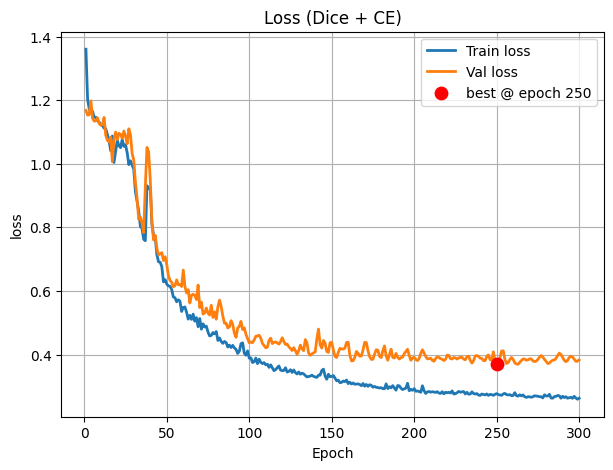

💾 Courbe sauvegardée : /home/usrs/hnoel/Tohoku/Monai/SegResNet/SegResNet_STARE_v1/dice.png


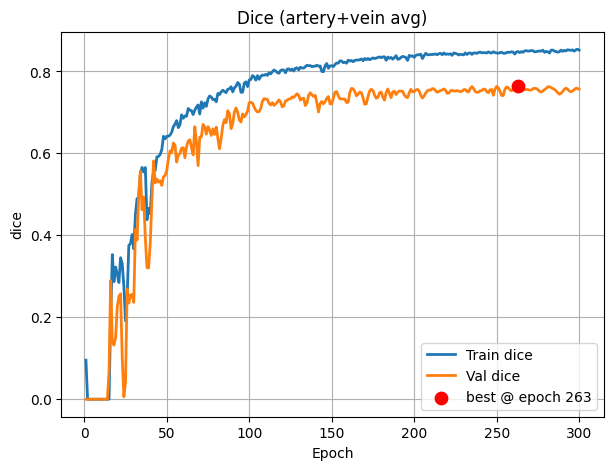

💾 Courbe sauvegardée : /home/usrs/hnoel/Tohoku/Monai/SegResNet/SegResNet_STARE_v1/auc.png


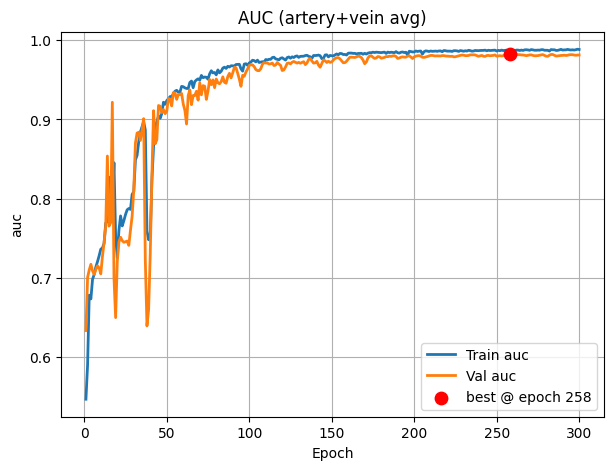

In [35]:
# Loss totale, Dice, AUC : même type de visualisation que dans ton notebook

plot_metric(train_history, val_history, "loss",
            title="Loss (Dice + CE)", mark_best_on="val_loss")

plot_metric(train_history, val_history, "dice",
            title="Dice (artery+vein avg)", mark_best_on="val_dice")

plot_metric(train_history, val_history, "auc",
            title="AUC (artery+vein avg)", mark_best_on="val_auc")

#### 10.4) Table of metrics

In [36]:
# ==== Évaluation globale sur le test ====

model.eval()

conf_sums_test = init_confmat_sums(num_classes=NUM_CLASSES)
auc_buf_test   = init_auc_buffers(classes=[VESSEL_CLASS])

with torch.no_grad():
    for batch in test_loader:
        imgs   = batch["image"].to(device)
        labels = batch["label"].to(device)   # (B,1,H,W)

        logits = model(imgs)                 # (B,2,H,W)
        preds  = logits.argmax(dim=1)        # (B,H,W)
        targets = labels.squeeze(1)          # (B,H,W)

        update_confmat_sums(conf_sums_test, preds, targets, NUM_CLASSES)
        update_auc_buffers(auc_buf_test, logits, targets)

vessel_metrics = compute_scalar_metrics_from_confmat(conf_sums_test, include_classes=[VESSEL_CLASS])
vessel_auc     = compute_mean_auc(auc_buf_test)

results = {
    "Vessel": {
        "accuracy":    vessel_metrics["accuracy"],
        "precision":   vessel_metrics["precision"],
        "recall":      vessel_metrics["recall"],
        "specificity": vessel_metrics["specificity"],
        "dice":        vessel_metrics["dice"],
        "IoU":         vessel_metrics["iou"],
        "AUC":         vessel_auc,
    }
}

df_global = pd.DataFrame(results).T.round(4)

print("\n=== Résultats globaux sur le test (FOV uniquement) ===\n")
display(df_global)

# Sauvegarde en CSV / JSON
metrics_csv_path  = data_dir / "metrics_global_test.csv"
metrics_json_path = data_dir / "metrics_global_test.json"

df_global.to_csv(metrics_csv_path)
df_global.to_json(metrics_json_path, orient="index")

print("→ Sauvegardé :")
print("  ", metrics_csv_path)
print("  ", metrics_json_path)


=== Résultats globaux sur le test (FOV uniquement) ===



accuracy  precision  recall  specificity    dice     IoU     AUC
Vessel    0.9587     0.8171  0.7822       0.9795  0.7992  0.6656  0.9784

→ Sauvegardé :
   /home/usrs/hnoel/Tohoku/Monai/SegResNet/SegResNet_STARE_v1/metrics_global_test.csv
   /home/usrs/hnoel/Tohoku/Monai/SegResNet/SegResNet_STARE_v1/metrics_global_test.json


#### 10.4) Comparaison of the images

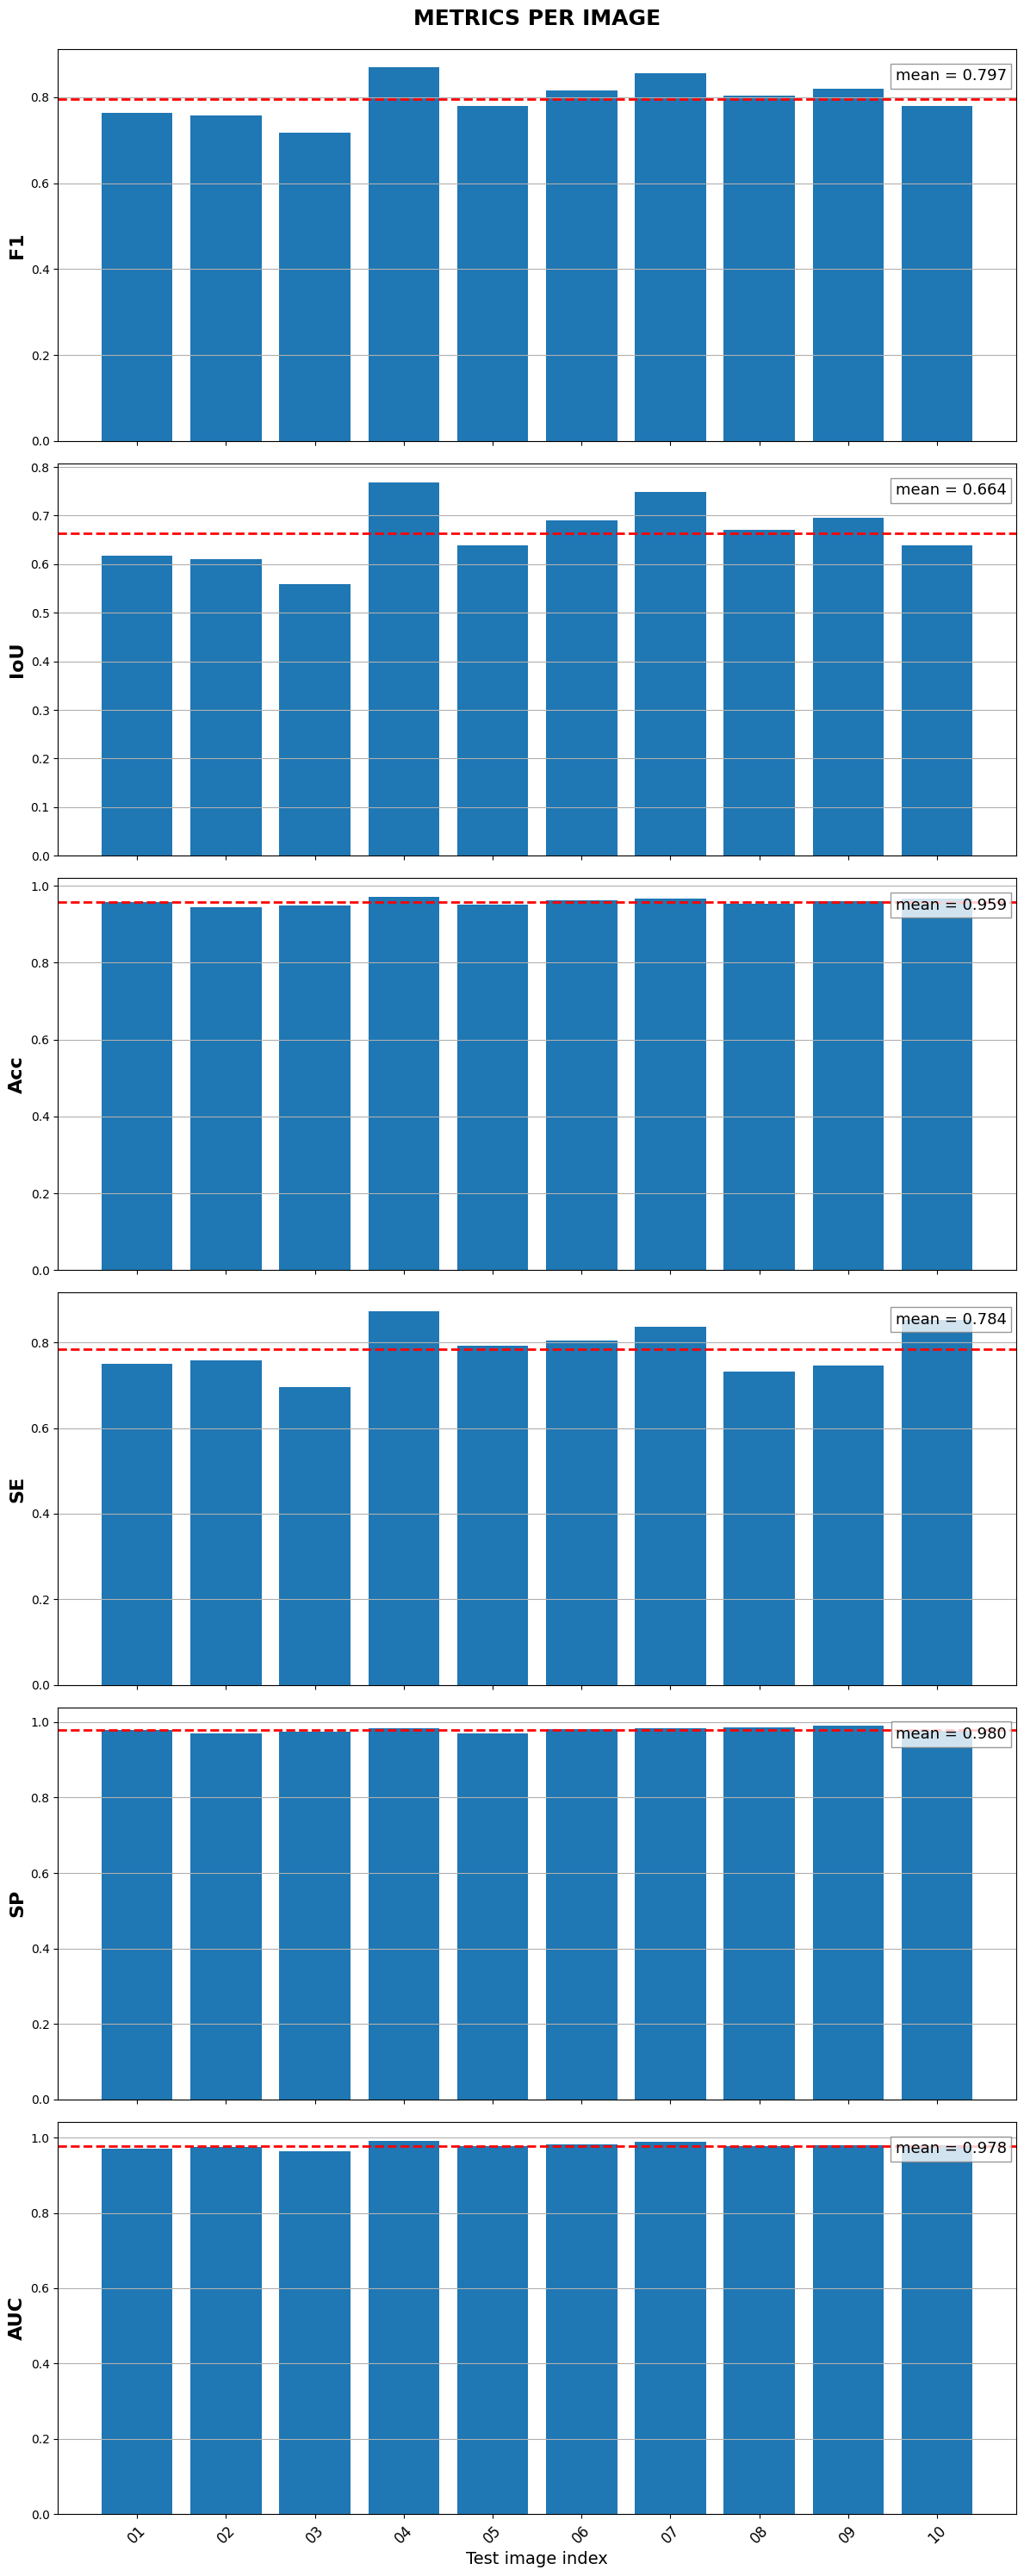

Sauvegardé : /home/usrs/hnoel/Tohoku/Monai/SegResNet/SegResNet_STARE_v1/per_image_metrics.png


In [38]:
# ==========================================================
#   Comparison of the images — Standalone (NO FOV version)
#   Fusion of the 3 original cells — produces final figure
# ==========================================================

# ---- HELPER FUNCTIONS ----

def confusion_binary(pred_bin: torch.Tensor, gt_bin: torch.Tensor):
    pred_bin = pred_bin.bool()
    gt_bin   = gt_bin.bool()
    TP = (pred_bin & gt_bin).sum().item()
    FP = (pred_bin & ~gt_bin).sum().item()
    FN = (~pred_bin & gt_bin).sum().item()
    TN = (~pred_bin & ~gt_bin).sum().item()
    return TP, FP, FN, TN


def metrics_from_conf(TP, FP, FN, TN):
    eps = 1e-7
    Acc  = (TP + TN) / max(TP + TN + FP + FN, eps)
    SE   = TP / max(TP + FN, eps)
    SP   = TN / max(TN + FP, eps)
    Prec = TP / max(TP + FP, eps)
    F1   = 2 * Prec * SE / max(Prec + SE, eps)
    IoU  = TP / max(TP + FP + FN, eps)
    return F1, IoU, Acc, SE, SP


def auc_from_logits_one_class(logits_1img, gt_1img, cls):
    with torch.no_grad():
        probs = F.softmax(logits_1img.unsqueeze(0), dim=1)[0]
        prob_cls = probs[cls]

        y_score = prob_cls.view(-1).cpu().numpy()
        y_true  = (gt_1img.view(-1) == cls).cpu().numpy().astype(np.uint8)

        if (y_true == 1).sum() == 0 or (y_true == 0).sum() == 0:
            return float("nan")

        try:
            return float(roc_auc_score(y_true, y_score))
        except:
            return float("nan")


# ==========================================================
#               METRICS PER IMAGE — FULL IMAGE ONLY
# ==========================================================

model.eval()

metric_names = ["F1", "IoU", "Acc", "SE", "SP", "AUC"]
scores_full = {m: [] for m in metric_names}

img_indices = []

with torch.no_grad():
    current_idx = 0
    for batch in test_loader:
        imgs   = batch["image"].to(device)
        labels = batch["label"].to(device)

        logits  = model(imgs)
        preds   = logits.argmax(dim=1)
        targets = labels.squeeze(1)

        for i in range(imgs.size(0)):
            gt_i   = targets[i]
            pred_i = preds[i]
            log_i  = logits[i]

            pred_v = (pred_i == VESSEL_CLASS)
            gt_v   = (gt_i == VESSEL_CLASS)

            TP, FP, FN, TN = confusion_binary(pred_v, gt_v)
            F1, IoU, Acc, SE, SP = metrics_from_conf(TP, FP, FN, TN)
            AUC = auc_from_logits_one_class(log_i, gt_i, VESSEL_CLASS)

            scores_full["F1"].append(F1)
            scores_full["IoU"].append(IoU)
            scores_full["Acc"].append(Acc)
            scores_full["SE"].append(SE)
            scores_full["SP"].append(SP)
            scores_full["AUC"].append(AUC)

            img_indices.append(current_idx)
            current_idx += 1

# ==========================================================
#               FINAL FIGURE (SAME AS LAST CELL)
#           BUT SINGLE COLUMN (NO FOV IN DATASET)
# ==========================================================

metric_names = ["F1", "IoU", "Acc", "SE", "SP", "AUC"]

fig, axes = plt.subplots(
    nrows=6, ncols=1, figsize=(12, 30), sharex=True
)

axes = axes.ravel()

axes[0].set_title("METRICS PER IMAGE", fontsize=18, fontweight="bold", pad=20)

for row, m in enumerate(metric_names):

    vals = np.array(scores_full[m], dtype=float)
    mean_val = np.nanmean(vals)

    ax = axes[row]
    ax.bar(np.arange(len(vals)), vals)
    ax.axhline(mean_val, color="red", linestyle="--", linewidth=2)

    ax.text(
        0.99, 0.92,
        f"mean = {mean_val:.3f}",
        transform=ax.transAxes,
        horizontalalignment="right",
        fontsize=13,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
    )

    ax.set_ylabel(m, fontsize=16, fontweight="bold")
    ax.grid(True, axis="y")


axes[-1].set_xticks(np.arange(len(vals)))
axes[-1].set_xticklabels(
    [f"{i+1:02d}" for i in range(len(vals))],
    rotation=45,
    fontsize=12
)
axes[-1].set_xlabel("Test image index", fontsize=14)

plt.tight_layout()

out_path = data_dir / "per_image_metrics.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Sauvegardé : {out_path}")


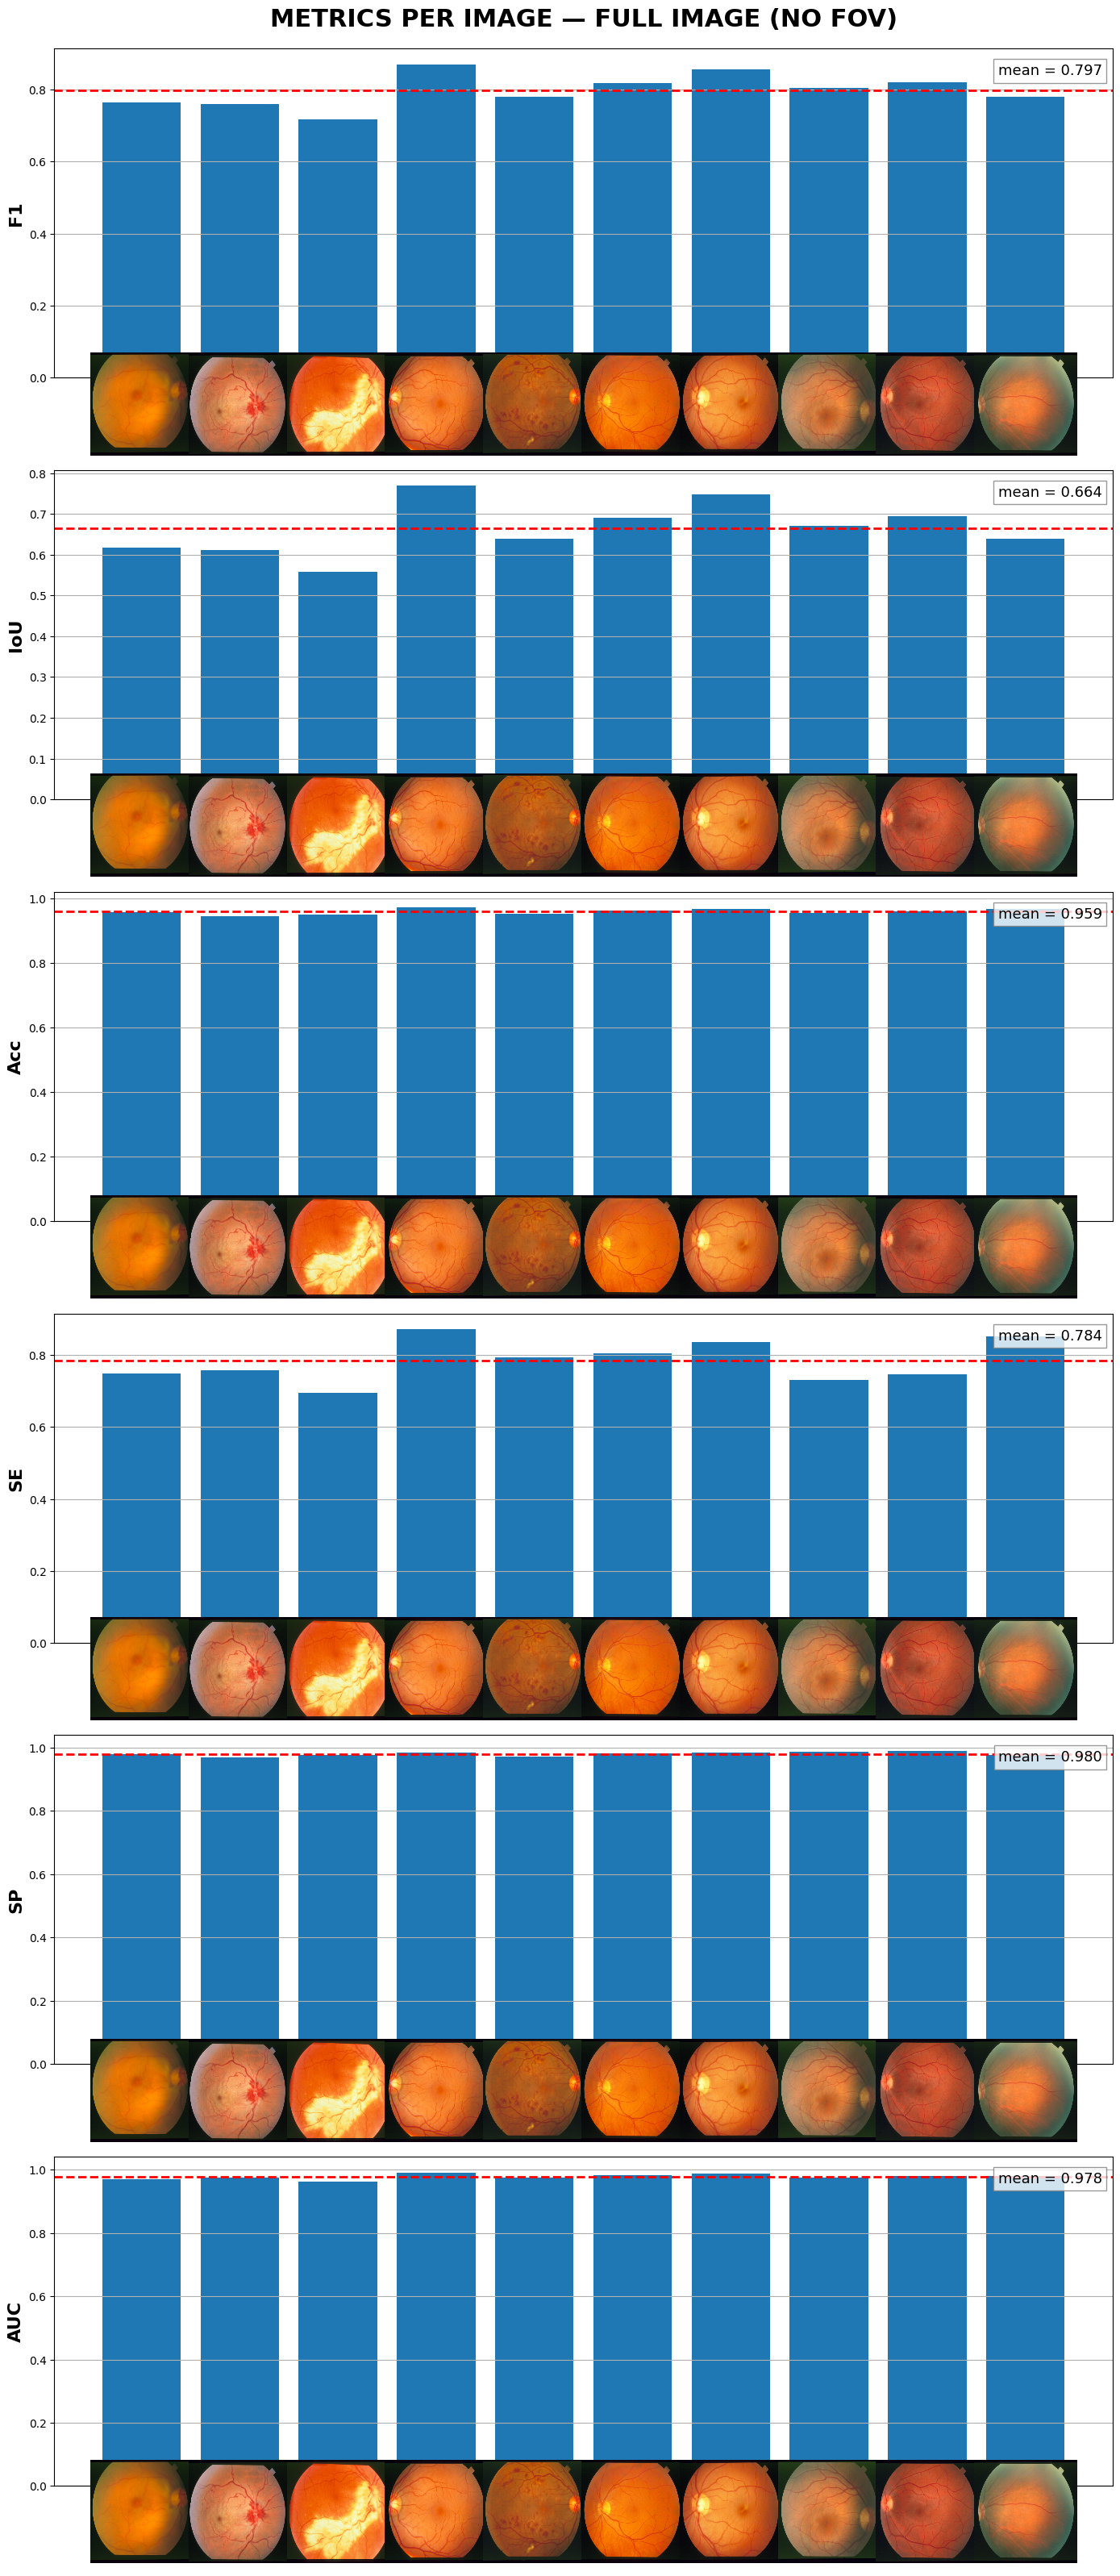

Sauvegardé : /home/usrs/hnoel/Tohoku/Monai/SegResNet/SegResNet_STARE_v1/per_image_metrics_FULLIMAGE_with_thumbnails.png


In [39]:
# ==========================================================
#   Comparison of the images — Standalone (NO FOV)
#   + Images below histogram bars
# ==========================================================

# ---- HELPER FUNCTIONS ----

def confusion_binary(pred_bin: torch.Tensor, gt_bin: torch.Tensor):
    pred_bin = pred_bin.bool()
    gt_bin   = gt_bin.bool()
    TP = (pred_bin & gt_bin).sum().item()
    FP = (pred_bin & ~gt_bin).sum().item()
    FN = (~pred_bin & gt_bin).sum().item()
    TN = (~pred_bin & ~gt_bin).sum().item()
    return TP, FP, FN, TN


def metrics_from_conf(TP, FP, FN, TN):
    eps = 1e-7
    Acc  = (TP + TN) / max(TP + TN + FP + FN, eps)
    SE   = TP / max(TP + FN, eps)
    SP   = TN / max(TN + FP, eps)
    Prec = TP / max(TP + FP, eps)
    F1   = 2 * Prec * SE / max(Prec + SE, eps)
    IoU  = TP / max(TP + FP + FN, eps)
    return F1, IoU, Acc, SE, SP


def auc_from_logits_one_class(logits_1img, gt_1img, cls):
    with torch.no_grad():
        probs = F.softmax(logits_1img.unsqueeze(0), dim=1)[0]
        prob_cls = probs[cls]

        y_score = prob_cls.view(-1).cpu().numpy()
        y_true  = (gt_1img.view(-1) == cls).cpu().numpy().astype(np.uint8)

        if (y_true == 1).sum() == 0 or (y_true == 0).sum() == 0:
            return float("nan")

        try:
            return float(roc_auc_score(y_true, y_score))
        except:
            return float("nan")


# ==========================================================
#               METRICS PER IMAGE — FULL IMAGE ONLY
# ==========================================================

model.eval()

metric_names = ["F1", "IoU", "Acc", "SE", "SP", "AUC"]
scores_full = {m: [] for m in metric_names}
img_indices = []
all_images = []  # stockage des images brutes pour affichage

with torch.no_grad():
    current_idx = 0
    for batch in test_loader:
        imgs   = batch["image"].to(device)
        labels = batch["label"].to(device)

        logits  = model(imgs)
        preds   = logits.argmax(dim=1)
        targets = labels.squeeze(1)

        for i in range(imgs.size(0)):
            gt_i   = targets[i]
            pred_i = preds[i]
            log_i  = logits[i]

            # Sauvegarde image originale pour affichage
            all_images.append(imgs[i].cpu().permute(1, 2, 0).numpy())

            pred_v = (pred_i == VESSEL_CLASS)
            gt_v   = (gt_i == VESSEL_CLASS)

            TP, FP, FN, TN = confusion_binary(pred_v, gt_v)
            F1, IoU, Acc, SE, SP = metrics_from_conf(TP, FP, FN, TN)
            AUC = auc_from_logits_one_class(log_i, gt_i, VESSEL_CLASS)

            scores_full["F1"].append(F1)
            scores_full["IoU"].append(IoU)
            scores_full["Acc"].append(Acc)
            scores_full["SE"].append(SE)
            scores_full["SP"].append(SP)
            scores_full["AUC"].append(AUC)

            img_indices.append(current_idx)
            current_idx += 1

# ==========================================================
#                FINAL FIGURE WITH IMAGES UNDER BARS
# ==========================================================

metric_names = ["F1", "IoU", "Acc", "SE", "SP", "AUC"]

fig, axes = plt.subplots(
    nrows=6, ncols=1, figsize=(14, 32), sharex=True
)

axes = axes.ravel()

axes[0].set_title("METRICS PER IMAGE — FULL IMAGE (NO FOV)", fontsize=22, fontweight="bold", pad=20)

n_images = len(all_images)
x = np.arange(n_images)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def add_image_under_bar(ax, img, xpos, y_bottom):
    imagebox = OffsetImage(img, zoom=0.13)
    ab = AnnotationBbox(imagebox, (xpos, y_bottom - 0.08),
                        xycoords=("data", "axes fraction"),
                        frameon=False)
    ax.add_artist(ab)

for row, m in enumerate(metric_names):

    vals = np.array(scores_full[m], dtype=float)
    mean_val = np.nanmean(vals)

    ax = axes[row]
    bars = ax.bar(x, vals)

    # Ligne de moyenne
    ax.axhline(mean_val, color="red", linestyle="--", linewidth=2)
    ax.text(
        0.99, 0.92,
        f"mean = {mean_val:.3f}",
        transform=ax.transAxes,
        horizontalalignment="right",
        fontsize=13,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
    )

    # Ajout des images sous chaque barre
    for j in range(n_images):
        img = all_images[j]
        add_image_under_bar(ax, img, j, 0)

    ax.set_ylabel(m, fontsize=16, fontweight="bold")
    ax.grid(True, axis="y")

axes[-1].set_xticks(x)
axes[-1].set_xticklabels([f"{i+1:02d}" for i in x], rotation=45, fontsize=12)
axes[-1].set_xlabel("Test image index", fontsize=14)

plt.tight_layout()

out_path = data_dir / "per_image_metrics_FULLIMAGE_with_thumbnails.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Sauvegardé : {out_path}")


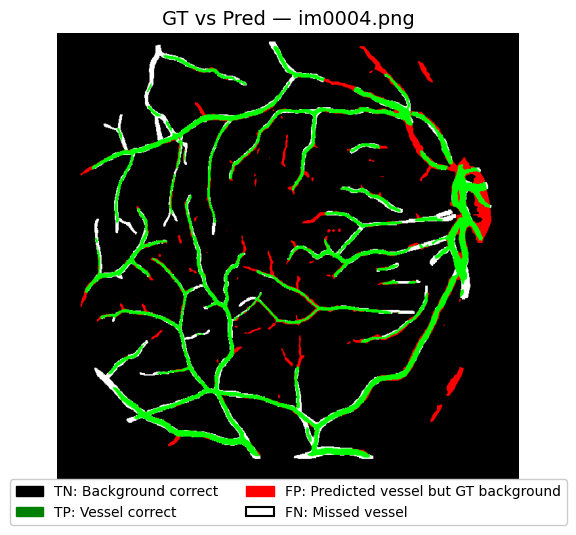

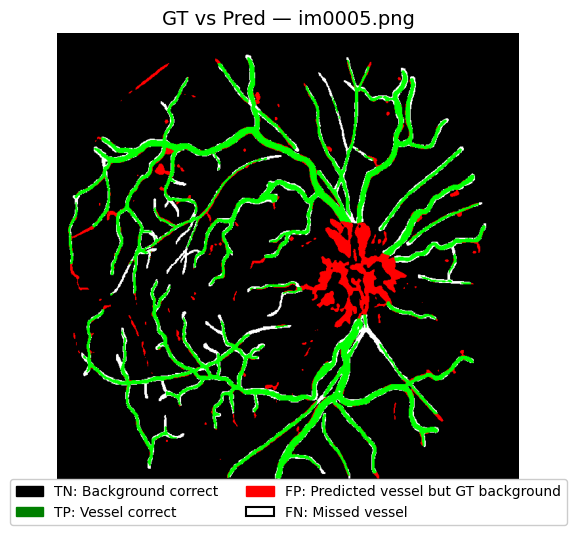

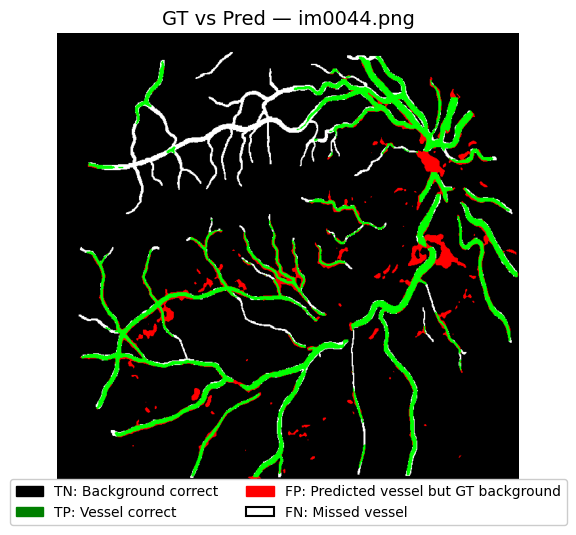

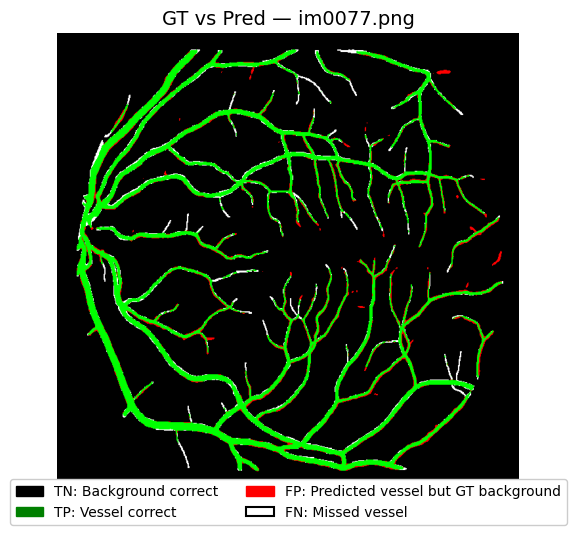

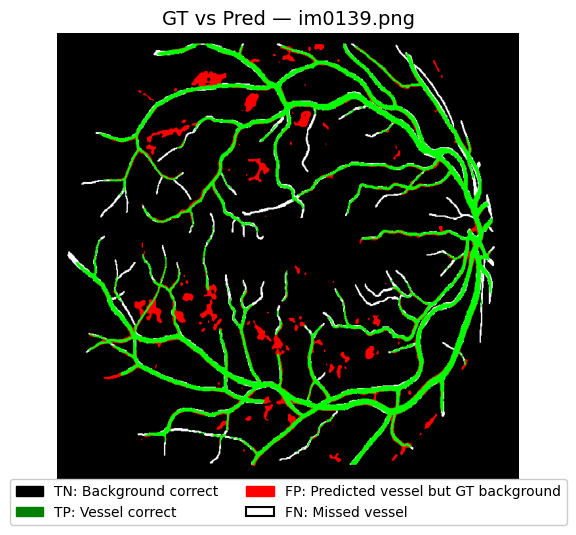

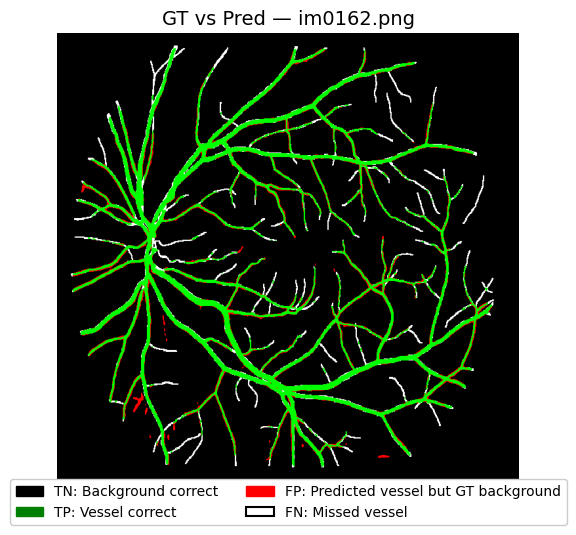

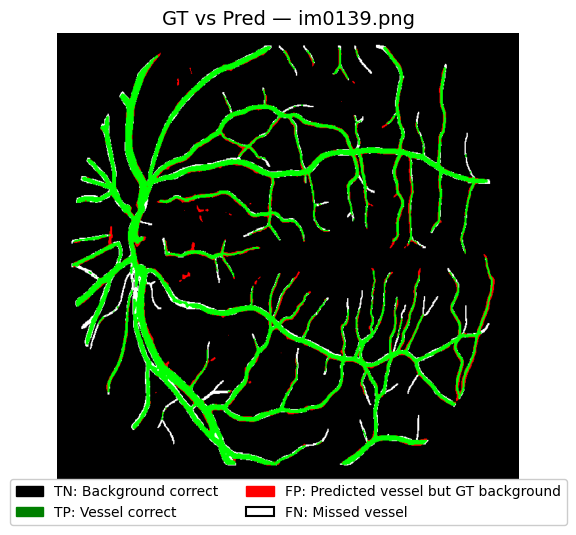

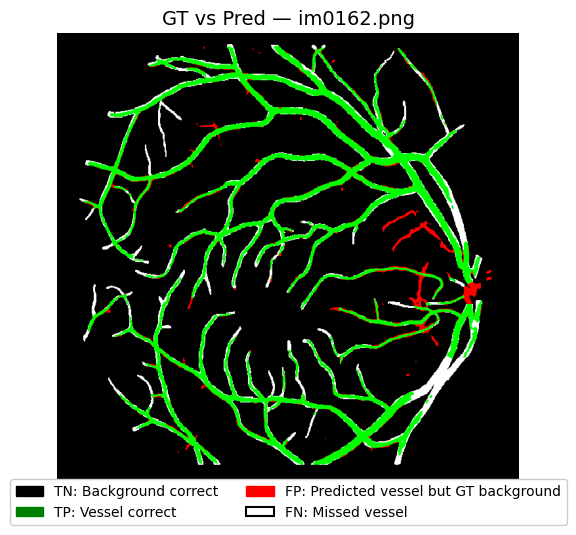

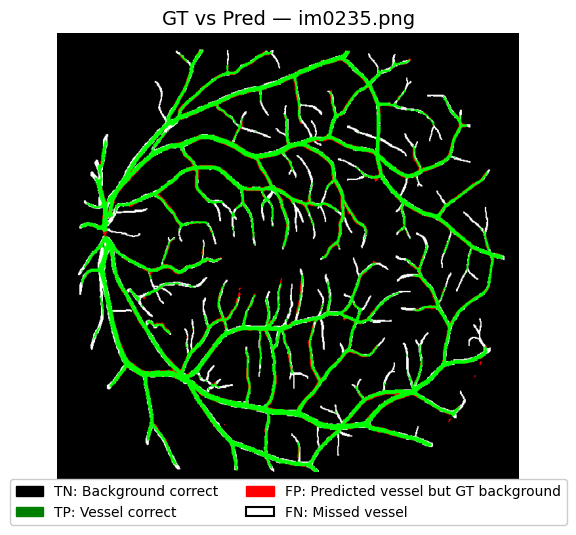

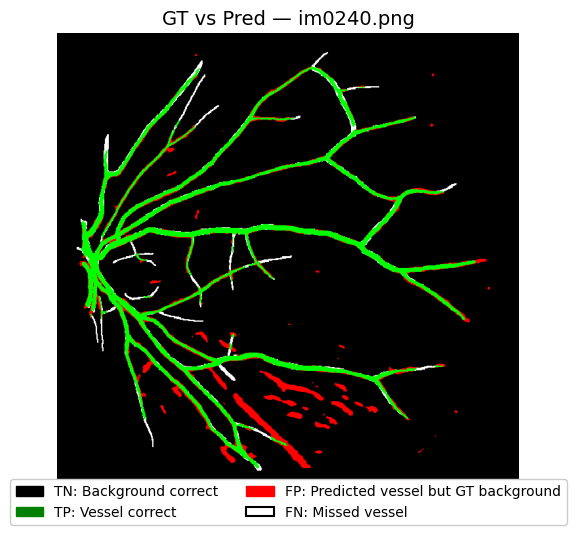

Overlays enregistrés dans : /home/usrs/hnoel/Tohoku/Monai/SegResNet/SegResNet_STARE_v1/overlays_test


In [40]:
# ==========================================================
#   Overlay GT vs Pred — With legend, filenames, saving
# ==========================================================

model.eval()

# 📁 Dossier pour sauvegarder les overlays
overlay_dir = data_dir / "overlays_test"
overlay_dir.mkdir(parents=True, exist_ok=True)

# Pour récupérer le nom réel des fichiers test (triés)
test_img_paths = sorted(list(test_images_dir.glob("*.png")))

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        imgs    = batch["image"].to(device)      # (B,3,H,W)
        labels  = batch["label"].to(device)      # (B,1,H,W)
        logits  = model(imgs)
        preds   = logits.argmax(dim=1)
        targets = labels.squeeze(1)

        batch_size = imgs.size(0)

        for i in range(batch_size):

            # Récupérer nom réel du fichier
            global_index = idx * batch_size + i
            img_name = test_img_paths[global_index].name

            # Tensors -> numpy
            gt  = (targets[i].cpu().numpy() == VESSEL_CLASS).astype(np.uint8)
            pr  = (preds[i].cpu().numpy()    == VESSEL_CLASS).astype(np.uint8)
            H, W = gt.shape

            # Overlay RGB
            overlay = np.zeros((H, W, 3), dtype=float)

            # TN (0,0) → noir
            mask_tn = (gt == 0) & (pr == 0)
            overlay[mask_tn] = [0, 0, 0]

            # TP (1,1) → vert
            mask_tp = (gt == 1) & (pr == 1)
            overlay[mask_tp] = [0, 1, 0]

            # FP (0,1) → rouge
            mask_fp = (gt == 0) & (pr == 1)
            overlay[mask_fp] = [1, 0, 0]

            # FN (1,0) → blanc
            mask_fn = (gt == 1) & (pr == 0)
            overlay[mask_fn] = [1, 1, 1]

            # ======== FIGURE ========
            fig, ax = plt.subplots(figsize=(6, 6))
            ax.imshow(overlay)
            ax.axis("off")
            ax.set_title(f"GT vs Pred — {img_name}", fontsize=14)

            # ======== LÉGENDE ========
            # On crée une "fake" légende avec des patches colorés
            import matplotlib.patches as mpatches
            legend_elems = [
                mpatches.Patch(color="black", label="TN: Background correct"),
                mpatches.Patch(color="green", label="TP: Vessel correct"),
                mpatches.Patch(color="red",   label="FP: Predicted vessel but GT background"),
                mpatches.Patch(facecolor="white", edgecolor="black", linewidth=1.5, label="FN: Missed vessel")
,
            ]
            ax.legend(handles=legend_elems, loc="lower center",
                      bbox_to_anchor=(0.5, -0.08),
                      fancybox=True, framealpha=1,
                      ncol=2)

            # ======== SAUVEGARDE ========
            save_path = overlay_dir / f"overlay_{global_index:02d}.png"
            plt.savefig(save_path, dpi=200, bbox_inches="tight")
            plt.show()

print(f"Overlays enregistrés dans : {overlay_dir}")
